In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# !pip install gensim


In [7]:

import nltk

import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


import gensim
from gensim.models import Word2Vec

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:

df = pd.read_csv("/content/drive/MyDrive/sentiment140.csv", encoding="latin-1", header=None)
df.columns = ["target", "ids", "date", "flag", "user", "text"]

# Keep only label and textdf = df[["target", "text"]]
df["target"] = df["target"].replace({4: 1})
df.head()


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(w) for w in text if w not in stop_words]
    return text

df["clean_text"] = df["text"].apply(preprocess)


texts = df["clean_text"].apply(lambda x: " ".join(x))
y = df["target"].values


Logistic Regression Accuracy: 0.7759
Naive Bayes Accuracy: 0.7654


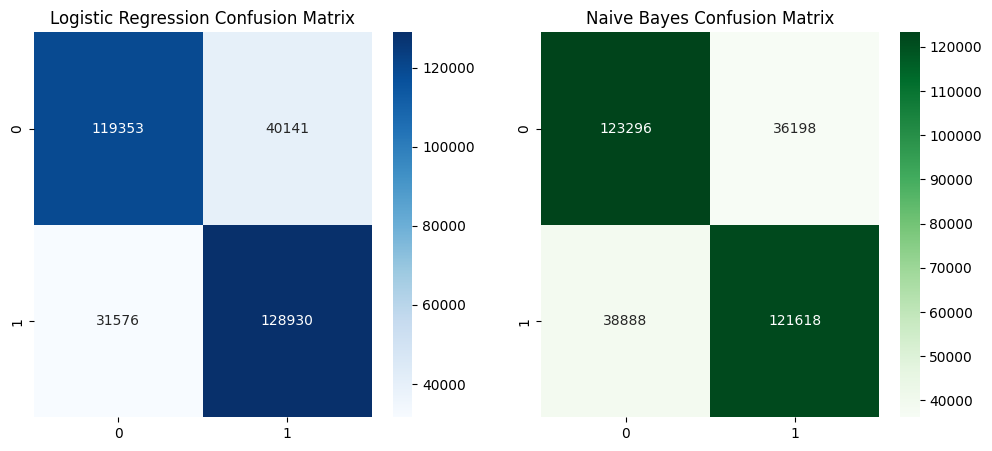

In [10]:

vectorizer = CountVectorizer(max_features=20000)
X_bow = vectorizer.fit_transform(texts)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42
)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Naive Bayes Accuracy: {acc_nb:.4f}")

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Naive Bayes Confusion Matrix")

plt.show()


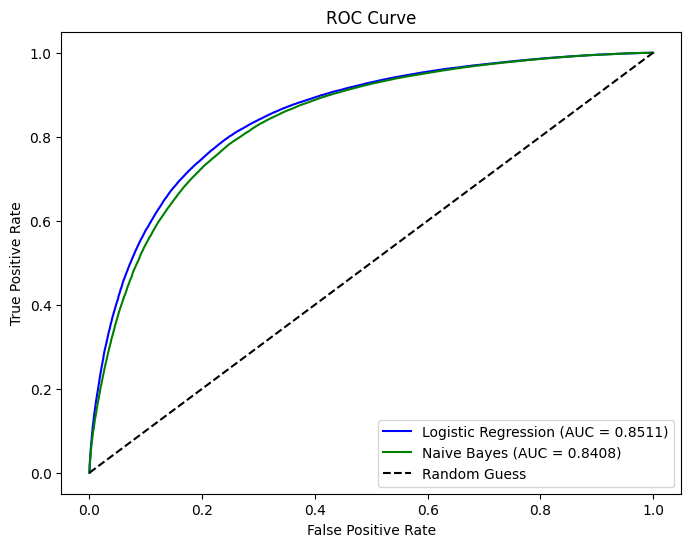

In [11]:

from sklearn.metrics import roc_curve, roc_auc_score


y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_prob_nb = nb.predict_proba(X_test)[:, 1]


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)


auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_nb = roc_auc_score(y_test, y_prob_nb)


plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.4f})", color="blue")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.4f})", color="green")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [12]:

sentences = df["clean_text"].tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


word_index = {word: idx+1 for idx, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_index) + 1


embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


def text_to_sequence(tokens):
    return [word_index.get(word, 0) for word in tokens]

X_seq = df["clean_text"].apply(text_to_sequence)
X_seq = pad_sequences(X_seq, maxlen=50, padding="post")

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y, test_size=0.2, random_state=42
)


In [13]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                    input_length=50, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    X_train_seq, y_train_seq,
    batch_size=128, epochs=3,
    validation_split=0.2
)

loss, acc = model.evaluate(X_test_seq, y_test_seq)
print(f"LSTM Test Accuracy: {acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 701s 87ms/step - accuracy: 0.7266 - loss: 0.5397 - val_accuracy: 0.7753 - val_loss: 0.4686
Epoch 2/3
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 775s 91ms/step - accuracy: 0.7714 - loss: 0.4731 - val_accuracy: 0.7828 - val_loss: 0.4547
Epoch 3/3
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 723s 89ms/step - accuracy: 0.7784 - loss: 0.4614 - val_accuracy: 0.7861 - val_loss: 0.4499
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 319s 32ms/step - accuracy: 0.7879 - loss: 0.4477
LSTM Test Accuracy: 0.7869


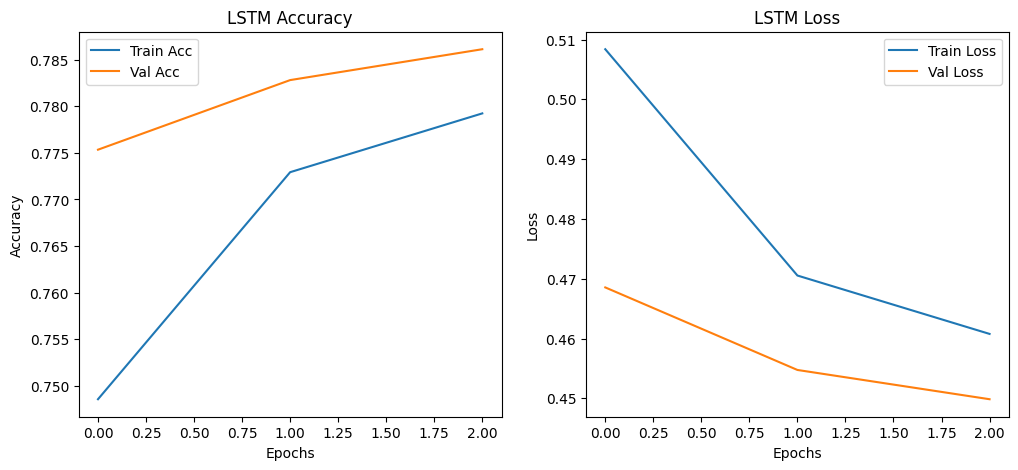

In [14]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("LSTM Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("LSTM Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step


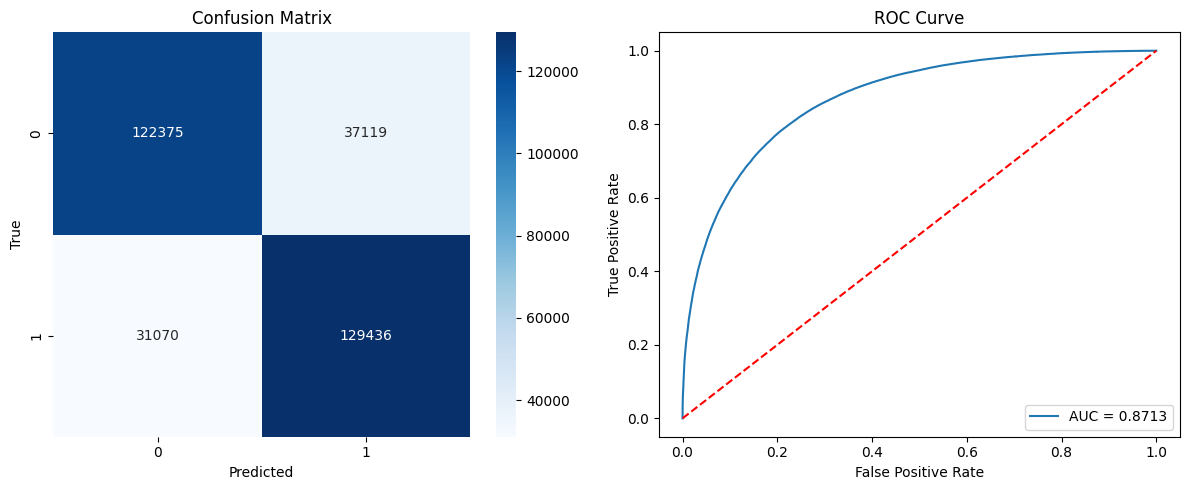

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns


y_pred_probs = model.predict(X_test_pad, batch_size=512)
y_pred_classes = (y_pred_probs > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")


fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "r--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


### 4. Reflection

- The **LSTM with Word2Vec embeddings** performed better than Bag of Words because it captures context and word order, while BoW only counts words.  
- Sequence models (like LSTM/GRU) are strong at handling variable-length text and learning semantic meaning, but they train slower and need more compute.  
- Bag of Words is simple, fast, and interpretable, but it loses all sequence information and treats words independently.  
- Transformers outperform both because self-attention captures global context and they benefit from large-scale pretraining.  
